# Testing Deferred Revenue in Python
Will this be easier for everyone to use than Matlab?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

# Processing Base Billings Data

In [2]:
df = pd.read_excel('../data/Data_2019_P06/base_billings.xlsx', sheet_name='bill_DC')

In [3]:
df.sample(10)

,Document Currency,Enterprise Bu,Frequency,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Revenue Recognition Category New,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales Doc Currency
27537,USD,Creative,NaN,2019-04,2Y,A,NaN,DEFERRED,12,7.602210e+04
25725,USD,Creative,ONGO,2015-07,1Y,D,Y1,DEFERRED,0,-7.333350e+03
20336,JPY,Document Cloud,NaN,2018-06,1Y,A,NaN,DEFERRED,0,6.920200e+05
27384,USD,Creative,ONGO,2018-12,NaN,NaN,NaN,RECOGNIZED,0,9.059060e+03
16969,GBP,Experience Cloud,1TME,2017-07,OUNIV,B,NaN,DEFERRED,0,4.354763e+04
18611,HKD,Creative,NaN,2019-03,1Y,D,Y3,DEFERRED,1,4.451359e+06
13416,EUR,Other Solutions,ONGO,2015-10,OUNIV,A,NaN,DEFERRED,0,1.341000e+04
14105,EUR,Print & Publishing,NaN,2018-07,1Y,D,YA,DEFERRED,0,7.429000e+04
32535,USD,LiveCycle,NaN,2015-09,1Y,NaN,NaN,DEFERRED,0,0.000000e+00
19774,JPY,Creative,NaN,2019-06,1Y,D,NaN,DEFERRED,0,1.163975e+08


## Changing the column names early since they are inconsistent across other reports

In [4]:
df.columns

Index(['Document Currency', 'Enterprise Bu', 'Frequency',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Revenue Recognition Category New', 'Rule For Bill Date', 'Sales Type',
       'Subscription Term', 'Completed Sales Doc Currency'],
      dtype='object')

In [5]:
df.rename(index = str, columns = {'Document Currency': 'curr',
                                 'Enterprise Bu': 'BU',
                                 'Invoicing Fiscal Year-Period Desc': 'period',
                                 'Product Configtype ID': 'config',
                                 'Rule For Bill Date': 'rebill_rule',
                                 'Completed Sales Doc Currency': 'amount'}, inplace=True)

In [6]:
df.columns

Index(['curr', 'BU', 'Frequency', 'period', 'config',
       'Revenue Recognition Category New', 'rebill_rule', 'Sales Type',
       'Subscription Term', 'amount'],
      dtype='object')

## Remove any currency that has  < 10 transactions. 


In [7]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['curr'].value_counts()

In [8]:
# Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index
# filtering the dataframe to remove any of teh currencies not in our list
df = df[df['curr'].isin(a)]

## Just keeping track of the currencies we removed in our model_dict data structure

In [9]:
remove_these = vc.values <= 10
model_dict = {'curr_removed': list(vc[remove_these].index)}
model_dict

{'curr_removed': ['ILS', 'BMD', 'INR', 'SAR', 'MXP']}

## Removing any of the values that are zero

In [10]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['amount']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  33945
This is the length of the dataframe after removing zeros:  31263


In [11]:
df.sample(10)

,curr,BU,Frequency,period,config,Revenue Recognition Category New,rebill_rule,Sales Type,Subscription Term,amount
22942,NOK,Document Cloud,NaN,2017-02,MTHLY,A,NaN,DEFERRED,1,-217.00
19416,JPY,Creative,NaN,2018-01,NaN,A,NaN,DEFERRED,1,-1960.00
28342,USD,Document Cloud,NaN,2017-09,MTHLY,A,NaN,DEFERRED,1,-14766.36
31050,USD,Experience Cloud,1TME,2017-09,NaN,D,YA,DEFERRED,0,12670.06
22722,NOK,Creative,NaN,2019-06,1Y,D,NaN,DEFERRED,1,127181.84
12392,EUR,Experience Cloud,ONGO,2018-01,OENSV,D,NaN,DEFERRED,0,7728.00
21333,JPY,Experience Cloud,1TME,2018-07,OCONS,NaN,NaN,PRO-SVC-INV,0,33730700.00
23190,NOK,Document Cloud,NaN,2019-01,MTHLY,D,Y3,DEFERRED,1,33574.00
20768,JPY,Experience Cloud,ONGO,2016-05,OENSV,D,NaN,DEFERRED,0,460000.00
1495,AUD,Document Cloud,NaN,2018-03,1Y,D,YA,DEFERRED,12,1196672.71


In [12]:
#df['curr'].value_counts()

## Clearing out the Non-Revenue billings from the file
 - No Idea what these are

In [13]:
df['Sales Type'].value_counts()

DEFERRED       24902
RECOGNIZED      5355
PRO-SVC-INV      906
NON-REV          100
Name: Sales Type, dtype: int64

In [14]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))


Length of the dataframe before removing non-revenue billings:  31263
Length of the dataframe after removing non-revenue billings:   31163


## Starting to group the revenue by period, industry, etc

Groupong the billings by the following categories
 - currency
 - period
 - sale type
 

DOING THIS ALL IN PANDAS WITH SPLIT APPLY COMBINE on Sales Type 

In [15]:
# First split the data into three dataframes
# Recognized billings
rec = df[df['Sales Type']=='RECOGNIZED']
svc = df[df['Sales Type']=='PRO-SVC-INV']
dfr = df[df['Sales Type']=='DEFERRED']

In [16]:
# Filter and group billings function will delete temporary datasets as completed
def filter_and_group(data2process, gblist, billings_type=None):
    """filter and group Base Billings Data"""
    
    #when a billings_type is supplied then filter, else just go to groupby below
    if billings_type:
        data2process = data2process[data2process['Revenue Recognition Category New']==billings_type]
    
    #groupby the columns passed in the function call then remove the subscription term column
    gb = data2process.groupby(gblist, as_index=False).sum()
    gb.drop(labels='Subscription Term', axis=1, inplace = True)
    return gb

In [17]:
gb_rec = filter_and_group( rec, ['curr', 'BU', 'period'])
gb_svc = filter_and_group( svc, ['curr', 'BU', 'period'])
gb_a = filter_and_group(dfr, ['curr', 'BU', 'period', 'config'],  'A')
gb_b = filter_and_group(dfr,['curr', 'BU', 'period'],  'B')
gb_d = filter_and_group(dfr,['curr', 'BU', 'period',
                     'rebill_rule'], 'D')

## NOW WORKING ON THE BILLINGS

### Recognized Revenue

In [18]:
#gb_rec.sample(10)

In [19]:
# testing groupby object
#gb_rec = rec.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [20]:
# the Subscription term hangs around. We are dropping that here
#gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [21]:
#gb_rec.sample(10)

In [22]:
#print(type(gb_rec))

### Service Billings

In [23]:
# testing groupby object
#gb_svc = svc.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [24]:
#gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)
#gb_svc.head(5)

### NOW WORKING ON DEFERRED BILLINGS

Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months

In [25]:
# filter out the type B first then do a group_by
#dfr_b = dfr[dfr['Revenue Recognition Category New']=='B']

In [26]:
#gb_b = dfr_b.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [27]:
#gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [28]:
#gb_b.head(10)

In [29]:
#print('length of deferred billings : ', len(dfr))
#print('length of the type B billings: ', len(dfr_b))

## Now Type A Billings
These billings are on a billing plan. The product config tells us how long before they renew

 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)
 

In [30]:
# filtering just the type A billings
#dfr_a = dfr[dfr['Revenue Recognition Category New']=='A']

In [31]:
#gb_a = dfr_a.groupby(['curr', 'BU', 'period',
#                     'config'], as_index=False).sum()
#gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [32]:
gb_a.sample(10)

,curr,BU,period,config,amount
2143,GBP,Print & Publishing,2017-09,1Y,294142.16
1180,EUR,Creative,2016-08,MTHLY,-22352.79
1231,EUR,Creative,2018-01,MTHLY,-44146.72
144,AUD,Document Cloud,2015-07,MTHLY,-81.82
16,AUD,Creative,2015-11,2Y,32399.50
1675,EUR,Print & Publishing,2018-09,1Y,659715.39
2420,JPY,Document Cloud,2017-07,1Y,53363930.00
1240,EUR,Creative,2018-04,MTHLY,-52061.14
1054,DKK,Document Cloud,2017-07,MTHLY,-433.79
19,AUD,Creative,2015-12,2Y,20414.00


In [33]:
gb_a['config'].value_counts()

1Y       1936
MTHLY     829
2Y        693
OUNIV     178
OCONS      62
3Y         58
ONORE      29
Name: config, dtype: int64

### Below is just a check to see how large the billing types are across all periods

In [34]:
gb_a_config = gb_a.groupby(['config'], as_index=False).sum()
gb_a_config

,config,amount
0,1Y,7.195507e+10
1,2Y,2.080207e+08
2,3Y,1.560911e+08
3,MTHLY,-1.638659e+07
4,OCONS,2.883743e+07
5,ONORE,2.260631e+06
6,OUNIV,3.412069e+06


### These 'OCONS', 'ONORE' and 'OUNIV' data types are not actual product config IDs so we have to get them from a different data file. We are excluding these types below.

In [35]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
test1 = gb_a['config'].isin(config_list)
sum(test1)

3516

In [36]:
test1 = gb_a[gb_a['config'].isin(config_list)]

## For now, lets just split this into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M


In [37]:
gb_a_1Y = test1[test1['config']=='1Y']
gb_a_2Y = test1[test1['config']=='2Y']
gb_a_3Y = test1[test1['config']=='3Y']
gb_a_1M = test1[test1['config']=='MTHLY']

In [38]:
print('this is the lenght of type A 1M billings: ', len(gb_a_1M))
print('this is the lenght of type A 1Y billings: ', len(gb_a_1Y))
print('this is the lenght of type A 2Y billings: ', len(gb_a_2Y))
print('this is the lenght of type A 3Y billings: ', len(gb_a_3Y))

this is the lenght of type A 1M billings:  829
this is the lenght of type A 1Y billings:  1936
this is the lenght of type A 2Y billings:  693
this is the lenght of type A 3Y billings:  58


## TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly [Y1, Y2, Y3, Y5]
 - Quarterly [YQ]
 - Every 4 months [YT]
 - Semi-annual [YH]
 - Annual [YA, YC]
 - Every 2 years - [Y4]
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [39]:
# for now just do a groupby on the type
# filtering just the type A billings
#dfr_d = dfr[dfr['Revenue Recognition Category New']=='D']

In [40]:
#gb_d = dfr_d.groupby(['curr', 'BU', 'period',
#                     'rebill_rule'], as_index=False).sum()
#gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [41]:
gb_d_mthly = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_d_qtrly = gb_d[gb_d['rebill_rule']=='YQ']
gb_d_four_mths = gb_d[gb_d['rebill_rule']=='YT']
gb_d_semi_ann = gb_d[gb_d['rebill_rule']=='YH']
gb_d_two_yrs = gb_d[gb_d['rebill_rule']=='Y4']

# these two have multiple rebill rules. We need to then group them by ['curr', 'BU', 'period'] 
# to avoid repeated lines when merged later
gb_d_mthly_pre = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_d_mthly = gb_d_mthly_pre.groupby(['curr', 'BU', 'period']).sum()
gb_d_annual_pre = gb_d[gb_d['rebill_rule'].isin(['YA', 'YC'])]
gb_d_annual = gb_d_annual_pre.groupby(['curr', 'BU', 'period']).sum()


In [42]:
# Need to sum the groups that have multiple rebill_rules or we end up with a duplicate when all of the items are merged
#gb_d_mthly.head(10)
#gb_d_mthly['rebill_rule'].value_counts()
#the_sum = gb_d_mthly['amount'].sum()
#print(the_sum)
#test_gb_d_mthly = gb_d_mthly.groupby(['curr', 'BU', 'period']).sum()
#new_sum = test_gb_d_mthly['amount'].sum()
#print(new_sum)

In [43]:
gb_d_mthly.head(10)

amount
curr BU             period             
ARS  Creative       2019-03   419565.00
                    2019-04  1894409.00
                    2019-05  3205378.29
                    2019-06  5731933.57
     Document Cloud 2019-04    16748.00
                    2019-05    31863.00
                    2019-06    68726.00
AUD  Creative       2015-06  4995447.52
                    2015-07  4119366.88
                    2015-08  4368698.07

In [44]:
#gb_d['rebill_rule'].value_counts()

In [45]:
#gb_d['curr'].value_counts()

### Note: There is one type D billings that is listed as 'BT' I don't know what this means, but it was a $180 EUR payment from January 2017, so we will ignore

In [46]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of four months', len(gb_d_four_mths))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))

Length of monthly 1721
Length of quarterly 571
Length of four months 8
Length of semi ann 255
Length of annual 1799
Length of two years 27


In [47]:
what_is_BT = gb_d[gb_d['rebill_rule']=='YT']
what_is_BT.head(10)

,curr,BU,period,rebill_rule,amount
4417,USD,Experience Cloud,2015-06,YT,11666.60
4431,USD,Experience Cloud,2015-08,YT,549861.11
4444,USD,Experience Cloud,2015-10,YT,11666.60
4464,USD,Experience Cloud,2016-01,YT,612916.60
4469,USD,Experience Cloud,2016-02,YT,-601250.00
4529,USD,Experience Cloud,2016-12,YT,13440.00
4553,USD,Experience Cloud,2017-04,YT,13440.00
4577,USD,Experience Cloud,2017-08,YT,13440.00


## Note: There are only 8 payments (back from 2017) that paid on a 4 month basis. 
We will ignore these as well.

## NOW WE NEED TO BUILD A DATAFRAME THAT INTEGRATES THIS DATA

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

In [48]:
# We need to do it this way when we get to a .py file!
list_df = [gb_rec, gb_svc, gb_b,
        gb_a_1M,    gb_a_1Y,    gb_a_2Y,       gb_a_3Y, 
        gb_d_mthly, gb_d_qtrly, gb_d_semi_ann, gb_d_annual, gb_d_two_yrs]

list_columns = ['recognized', 'service', 'deferred_B', 
    'deferred_1M_a', 'deferred_1Y_a', 'deferred_2Y_a', 'deferred_3Y_a',
    'deferred_1M_d', 'deferred_3M_d', 'deferred_6M_d', 'deferred_1Y_d', 'deferred_2Y_d']


In [49]:
def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'amount': new_column}, inplace=True)
        
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged

In [50]:
def merge_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        print('This is i:', i)
        #print("This is the df: ", df.head())
        print('referencing the column: ', list_columns[i])

        if i==0:
            df_merged = list_df[0]
            df_merged.rename(index=str, columns={'amount': list_columns[i]}, inplace=True)
        else:
            df_merged = merge_new_dataframe(df_merged, df, list_columns[i])

    return df_merged
    

In [51]:
df = merge_all_dataframes(list_df, list_columns)

This is i: 0
referencing the column:  recognized
This is i: 1
referencing the column:  service
This is i: 2
referencing the column:  deferred_B
This is i: 3
referencing the column:  deferred_1M_a
This is i: 4
referencing the column:  deferred_1Y_a
This is i: 5
referencing the column:  deferred_2Y_a
This is i: 6
referencing the column:  deferred_3Y_a
This is i: 7
referencing the column:  deferred_1M_d
This is i: 8
referencing the column:  deferred_3M_d
This is i: 9
referencing the column:  deferred_6M_d
This is i: 10
referencing the column:  deferred_1Y_d
This is i: 11
referencing the column:  deferred_2Y_d


In [52]:
df.head(10)

,curr,BU,period,recognized,service,deferred_B,deferred_1M_a,deferred_1Y_a,deferred_2Y_a,deferred_3Y_a,deferred_1M_d,deferred_3M_d,deferred_6M_d,deferred_1Y_d,deferred_2Y_d
0,AUD,Creative,2015-06,490156.86,NaN,NaN,-2758.57,2601332.25,26443.20,NaN,4995447.52,NaN,NaN,3226774.85,NaN
1,AUD,Creative,2015-07,235045.62,NaN,NaN,-3380.48,2669684.62,10399.50,NaN,4119366.88,NaN,NaN,2341510.15,NaN
2,AUD,Creative,2015-08,284334.70,NaN,NaN,-2883.40,2661794.06,2316.62,NaN,4368698.07,NaN,NaN,1327729.48,NaN
3,AUD,Creative,2015-09,369648.88,NaN,NaN,-4480.56,3646842.53,11534.00,NaN,5669560.02,NaN,NaN,2194183.65,NaN
4,AUD,Creative,2015-10,287292.48,NaN,NaN,-3188.41,2547182.54,11802.30,NaN,4649336.15,NaN,NaN,1897555.57,NaN
5,AUD,Creative,2015-11,361723.22,NaN,NaN,-5882.06,1731502.65,32399.50,NaN,5083456.05,NaN,NaN,1750356.35,NaN
6,AUD,Creative,2015-12,276178.28,NaN,NaN,-3511.62,4852252.69,20414.00,NaN,6504775.23,NaN,NaN,6837563.10,NaN
7,AUD,Creative,2016-01,270306.21,NaN,NaN,-3691.27,2153684.38,37020.00,NaN,6706754.92,NaN,NaN,1568587.72,NaN
8,AUD,Creative,2016-02,116996.45,NaN,NaN,-4004.69,1599637.04,6992.00,NaN,5467807.06,NaN,NaN,2558415.43,NaN
9,AUD,Creative,2016-03,235382.84,NaN,NaN,-8805.69,2615203.82,36388.00,NaN,7499720.70,NaN,NaN,3129145.48,NaN


In [53]:
#df['curr'].value_counts()

In [54]:
def clean_df_columns(df):
    
    # clean up NaNs before adding 
    df = df.fillna(value=0)
    
    # Monthly
    df['deferred_1M'] = df['deferred_1M_a']+df['deferred_1M_d']
    df.drop(labels=['deferred_1M_a', 'deferred_1M_d'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y'] = df['deferred_1Y_a']+df['deferred_1Y_d']
    df.drop(labels=['deferred_1Y_a', 'deferred_1Y_d'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y'] = df['deferred_2Y_a']+df['deferred_2Y_d']
    df.drop(labels=['deferred_2Y_a', 'deferred_2Y_d'], axis=1, inplace=True)
    
    # renaming 3Y, 3M and 6M
    df.rename(index=str, columns = {'deferred_3Y_a':'deferred_3Y', 'deferred_3M_d':'deferred_3M', 
                               'deferred_6M_d': 'deferred_6M'}, inplace=True)

    #cleaning up the longer column names
    df.rename(index=str, columns = {'curr': 'curr',
                               'BU':'BU',
                               'period':'period'}, inplace=True)
    
    return df

In [55]:
df = clean_df_columns(df)

In [56]:
df.sample(10)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_3M,deferred_6M,deferred_1M,deferred_1Y,deferred_2Y
2714,RUB,Document Cloud,2019-04,0.00,0.0,0.0,0.0,0.00,0.0,493983.60,118694.00,0.0
171,AUD,LiveCycle,2017-06,6754.80,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0
837,EUR,Creative,2018-12,1798693.78,0.0,27720.0,0.0,1303.76,0.0,42720594.30,70149553.98,511553.2
2469,DKK,Document Cloud,2017-11,0.00,0.0,0.0,0.0,0.00,0.0,132417.50,217764.10,0.0
265,BRL,Creative,2019-06,53563.00,0.0,0.0,0.0,0.00,0.0,10232820.79,1045725.58,0.0
173,AUD,LiveCycle,2017-08,4796.95,0.0,0.0,0.0,0.00,0.0,0.00,23337.10,0.0
772,DKK,Print & Publishing,2016-08,6430.00,0.0,0.0,0.0,0.00,0.0,19623.30,0.00,0.0
404,CHF,Document Cloud,2016-07,15752.00,0.0,0.0,0.0,0.00,0.0,26888.05,42741.37,0.0
1112,GBP,Creative,2017-06,326766.87,0.0,0.0,0.0,0.00,0.0,11565661.72,8777300.13,11283.8
1730,NOK,Document Cloud,2017-04,2805.00,0.0,0.0,0.0,0.00,0.0,196036.57,340705.28,0.0


In [57]:
#df.curr.value_counts()

In [58]:
# Make this a function to be cleaned up somehow
del dfr
#del dfr_a
#del dfr_b
#del dfr_d
del gb_a
del gb_a_1M
del gb_a_1Y
del gb_a_2Y
del gb_a_3Y
del gb_b, 
del gb_d
del gb_svc, gb_rec, gb_d_two_yrs
del gb_d_four_mths, gb_d_qtrly, gb_d_semi_ann


# Now working on the ZCC billings

These billings are type D billings that did not populate the rebill_rule field of the database.

They have a 'sales document type' = 'ZCC"

The billings themselves are being created from a tableau report that looks for additions to the deferred revenue waterfall based on billings of type D and have a sales document type of ZCC

In [59]:
df.sample(10)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_3M,deferred_6M,deferred_1M,deferred_1Y,deferred_2Y
572,CHF,Print & Publishing,2018-11,10957.00,0.00,0.00,0.0,0.00,0.0,4334.45,-33.00,0.00
720,DKK,LiveCycle,2016-01,1780.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00
335,CAD,LiveCycle,2018-09,2884.05,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00
1641,JPY,Print & Publishing,2018-03,13689320.00,0.00,0.00,0.0,0.00,0.0,1040995.00,5660535.00,0.00
2072,SEK,LiveCycle,2017-10,7908.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00
2687,HKD,Document Cloud,2019-04,0.00,0.00,0.00,0.0,0.00,0.0,36728.42,49368.00,0.00
305,CAD,Experience Cloud,2018-04,51094.69,167974.54,22880.35,0.0,254507.91,0.0,0.00,5031313.43,0.00
36,AUD,Creative,2018-06,207143.04,0.00,0.00,0.0,0.00,0.0,16560453.31,9399261.27,2727.72
1963,SEK,Document Cloud,2016-04,114320.00,0.00,0.00,0.0,0.00,0.0,175225.95,233531.56,0.00
1728,NOK,Document Cloud,2017-02,13986.00,0.00,0.00,0.0,0.00,0.0,189752.51,362074.18,0.00


# TO BE DONE:

1. Clean up the type F billings (at least check to see if they are necessary)
2. Make a function to delete all intermediate dataframes
3. Add type A no config function
4. Add type D ZCC billings

5. Work on the forecast part of this

6. Load up FX rates

In [60]:
# Adobe financial calendar
df_cal = pd.read_excel('../data/Data_2019_P06/ADOBE_FINANCIAL_CALENDAR.xlsx', 'ADBE_cal')

In [61]:
df_cal.head()

,Year,Quarter,Period,Qtr_Ticker,Qtr_Start,Qtr_End,Per_Ticker,Per_Start,Per_End
0,2010,1,1,Q1_10,2009-11-28,2010-03-05,P1_10,2009-11-28,2010-01-01
1,2010,1,2,Q1_10,2009-11-28,2010-03-05,P2_10,2010-01-02,2010-01-29
2,2010,1,3,Q1_10,2009-11-28,2010-03-05,P3_10,2010-01-30,2010-03-05
3,2010,2,4,Q2_10,2010-03-06,2010-06-04,P4_10,2010-03-06,2010-04-02
4,2010,2,5,Q2_10,2010-03-06,2010-06-04,P5_10,2010-04-03,2010-04-30


## ZCC Billings

In [62]:
df_ZCC = pd.read_excel('../data/Data_2019_P06/type_D_ZCC_billings.xlsx', sheet_name='DC')

In [63]:
df_ZCC.sample(10)

,Document Currency,Enterprise BU Description,Rev Rec Category,Rule for Bill Date Code,Week of FICA Posting Date (YYYYMMDD) (copy),DF Additions - Doc Curr
4881,USD,Experience Cloud,D,YQ,2015-12-06,-174487.19
1833,EUR,Experience Cloud,D,YA,2018-01-07,886298.40
1991,EUR,Experience Cloud,D,YH,2018-09-23,36666.56
3338,JPY,Experience Cloud,D,YA,2015-10-04,37400000.00
3698,SEK,Experience Cloud,D,YQ,2018-09-30,45306.00
2211,EUR,Print & Publishing,D,YA,2019-06-02,NaN
1911,EUR,Experience Cloud,D,YC,2017-06-25,8000.00
642,AUD,Experience Cloud,D,YQ,2017-08-27,168381.40
5013,USD,Experience Cloud,D,YQ,2016-12-04,1182390.98
15,AUD,Creative,D,YA,2018-07-15,48582.24


### Renaming the columns

In [64]:
df_ZCC.columns

Index(['Document Currency', 'Enterprise BU Description', 'Rev Rec Category',
       'Rule for Bill Date Code',
       'Week of FICA Posting Date (YYYYMMDD) (copy)',
       'DF Additions - Doc Curr'],
      dtype='object')

In [65]:
df_ZCC.rename(index = str, columns = {'Document Currency': 'curr',
                                      'Enterprise BU Description':'BU',
                                      'Rule for Bill Date Code': 'rebill_rule',
                                      'Week of FICA Posting Date (YYYYMMDD) (copy)': 'fiscal_week',
                                      'DF Additions - Doc Curr': 'amount'}, inplace = True)

In [66]:
df_ZCC.columns

Index(['curr', 'BU', 'Rev Rec Category', 'rebill_rule', 'fiscal_week',
       'amount'],
      dtype='object')

### Checking that we do not have any currencies that need to be removed


In [67]:
df_ZCC['curr'].value_counts()

USD    1415
EUR     926
AUD     716
GBP     678
JPY     558
CAD     328
DKK     177
SEK     174
CHF     116
NOK      76
SGD       1
Name: curr, dtype: int64

In [68]:
model_dict

{'curr_removed': ['ILS', 'BMD', 'INR', 'SAR', 'MXP']}

In [69]:
ZCC_curr = df_ZCC['curr'].unique()

In [70]:
for item in ZCC_curr:
    if item in model_dict['curr_removed']:
        print('This currency needs to be removed: ', item)

There are no currencies that need to be removed

# Now we are clearing out nans

In [71]:
print('Number of NaNs to be cleared out: ', sum(df_ZCC['amount'].isna()))
ZCC_isna = df_ZCC['amount'].isna()
print("This is the length of the ZCC records before clearing NAs: ", len(df_ZCC))
df_ZCC = df_ZCC[~ZCC_isna]
print("This is the length of the ZCC records before clearing NAs: ", len(df_ZCC))

Number of NaNs to be cleared out:  44
This is the length of the ZCC records before clearing NAs:  5165
This is the length of the ZCC records before clearing NAs:  5121


In [72]:
df_cal.sample(5)

,Year,Quarter,Period,Qtr_Ticker,Qtr_Start,Qtr_End,Per_Ticker,Per_Start,Per_End
47,2013,4,12,Q4_13,2013-08-31,2013-11-29,P12_13,2013-10-26,2013-11-29
198,2026,3,7,Q3_26,2026-05-30,2026-08-28,P7_26,2026-05-30,2026-06-26
20,2011,3,9,Q3_11,2011-06-04,2011-09-02,P9_11,2011-07-30,2011-09-02
224,2028,3,9,Q3_28,2028-06-03,2028-09-01,P9_28,2028-07-29,2028-09-01
106,2018,4,11,Q4_18,2018-09-01,2018-11-30,P11_18,2018-09-29,2018-10-26


In [73]:
df_ZCC.sample(10)

,curr,BU,Rev Rec Category,rebill_rule,fiscal_week,amount
2735,GBP,Experience Cloud,D,YH,2018-12-30,74781.80
3757,USD,Creative,D,YA,2017-07-09,11700.00
4229,USD,Experience Cloud,D,Y1,2017-06-25,3186653.55
4885,USD,Experience Cloud,D,YQ,2017-05-14,-52305.35
2462,GBP,Experience Cloud,D,Y1,2018-04-29,101.00
1018,CAD,Experience Cloud,D,YQ,2016-08-28,234921.12
2519,GBP,Experience Cloud,D,YA,2019-03-17,57285.00
22,AUD,Creative,D,YA,2018-09-16,59751.78
2936,GBP,Print & Publishing,D,YA,2019-05-26,30956.45
1102,CHF,Experience Cloud,D,YA,2018-10-28,77562.50


In [74]:
def add_ZCC_periods(df_ZCC, df_cal):
    ''' 
    Takes each ZCC period billing and maps it to the fiscal calendar then assignes the
    ZCC billing to the dataframe df
    '''
    period_list = []
    
    for i in range(len(df_ZCC)):
        # this_date is the date we need mapped to a period
        this_date = df_ZCC['fiscal_week'].iloc[i]
        
        #max index will be the index to the period in our financial calendar
        this_index = df_cal['Per_End']<=this_date
        max_index = sum(this_index)

        this_year = df_cal['Year'].iloc[max_index].astype(str)
        this_period= df_cal['Period'].iloc[max_index].astype(str)

        # formatting the period string from the calendar
        if len(this_period)== 1:
            this_period = '0'+this_period

        period_ticker = this_year + '-' + this_period

        period_list.append(period_ticker)

    df_ZCC['period'] = period_list
    return df_ZCC


In [75]:
df_ZCC.head()

,curr,BU,Rev Rec Category,rebill_rule,fiscal_week,amount
1,AUD,Creative,D,YA,2019-04-21,-3254.76
2,AUD,Creative,D,YA,2017-07-16,2070.00
3,AUD,Creative,D,YA,2017-05-28,4560.00
4,AUD,Creative,D,YA,2018-01-07,6657.92
5,AUD,Creative,D,YA,2017-12-31,8274.87


In [76]:
df_ZCC = add_ZCC_periods(df_ZCC, df_cal)

In [77]:
df_ZCC.tail()

,curr,BU,Rev Rec Category,rebill_rule,fiscal_week,amount,period
5160,USD,Print & Publishing,D,YC,2018-12-16,8000.00,2019-01
5161,USD,Print & Publishing,D,YC,2018-12-30,14745.00,2019-02
5162,USD,Print & Publishing,D,YC,2019-02-24,17218.60,2019-03
5163,USD,Print & Publishing,D,YH,2018-12-30,3256.50,2019-02
5164,USD,Print & Publishing,D,YQ,2019-03-24,201.75,2019-04


In [78]:
#df_ZCC.curr.value_counts()

## Now we need to determine the length of the ZCC billings to and add this to our dataframe

In [79]:
df.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_3M', 'deferred_6M', 'deferred_1M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [80]:
df_ZCC.columns

Index(['curr', 'BU', 'Rev Rec Category', 'rebill_rule', 'fiscal_week',
       'amount', 'period'],
      dtype='object')

In [81]:
gb_ZCC = df_ZCC.groupby(['curr', 'BU', 'period',
                     'rebill_rule'], as_index=False).sum()
#gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [82]:
gb_ZCC.sample(20)

,curr,BU,period,rebill_rule,amount
675,EUR,Experience Cloud,2015-04,YH,40001.22
1543,SEK,Experience Cloud,2018-11,YQ,280410.77
186,AUD,Experience Cloud,2018-09,Y1,219508.65
364,CAD,Experience Cloud,2018-08,YA,327809.36
1925,USD,Experience Cloud,2018-12,Y1,4945205.34
920,EUR,Print & Publishing,2018-11,YA,43271.83
1495,SEK,Experience Cloud,2016-07,YA,3557895.48
1506,SEK,Experience Cloud,2016-12,YQ,1410542.13
1666,USD,Experience Cloud,2015-04,YQ,5210476.54
1981,USD,Print & Publishing,2019-02,YC,14745.00


In [83]:
gb_ZCC['rebill_rule'].value_counts()

YA    783
YQ    438
YH    245
Y1    235
YC    203
Y3     72
Y4     11
YX      2
Name: rebill_rule, dtype: int64

In [84]:
#gb_ZCC.curr.value_counts()

In [85]:
gb_ZCC_qtrly = gb_ZCC[gb_ZCC['rebill_rule']=='YQ']
gb_ZCC_four_mths = gb_ZCC[gb_ZCC['rebill_rule']=='YT']
gb_ZCC_semi_ann = gb_ZCC[gb_ZCC['rebill_rule']=='YH']
gb_ZCC_two_yrs = gb_ZCC[gb_ZCC['rebill_rule']=='Y4']

# these two have multiple rebill rules. We need to then group them by ['curr', 'BU', 'period'] 
# to avoid repeated lines when merged later

gb_ZCC_mthly_pre = gb_ZCC[gb_ZCC['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_ZCC_annual_pre = gb_ZCC[gb_ZCC['rebill_rule'].isin(['YA', 'YC'])]

gb_ZCC_mthly = gb_ZCC_mthly_pre.groupby(['curr', 'BU', 'period']).sum()
gb_ZCC_annual = gb_ZCC_annual_pre.groupby(['curr', 'BU', 'period']).sum()


There are no four month billings

In [86]:
len(gb_ZCC_four_mths)

0

There are two YX billings for small amounts that I do not have mapped to a frequency.
They will be ignored

In [87]:
what_is_YX = gb_ZCC[gb_ZCC['rebill_rule']=='YX']
what_is_YX.head(10)

,curr,BU,period,rebill_rule,amount
645,EUR,Document Cloud,2017-12,YX,0.0
1220,JPY,Document Cloud,2018-11,YX,1522800.0


## I need to merge the ZCC billings and then clean up the columns. 
 


In [88]:
# We need to do it this way when we get to a .py file!
list_ZCC_df = [gb_ZCC_mthly, gb_ZCC_qtrly, gb_ZCC_semi_ann,
           gb_ZCC_annual, gb_ZCC_two_yrs]

list_ZCC_columns = ['deferred_1M', 'deferred_3M', 'deferred_6M', 
    'deferred_1Y', 'deferred_2Y']


In [89]:
df_ZCC_merged = merge_all_dataframes(list_ZCC_df, list_ZCC_columns)

This is i: 0
referencing the column:  deferred_1M
This is i: 1
referencing the column:  deferred_3M
This is i: 2
referencing the column:  deferred_6M
This is i: 3
referencing the column:  deferred_1Y
This is i: 4
referencing the column:  deferred_2Y


In [90]:
df_ZCC_merged.sample(10)

,curr,BU,period,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
212,USD,Experience Cloud,2017-03,6373958.85,20641807.33,2014968.22,34203718.95,NaN
581,CAD,Print & Publishing,2019-03,NaN,NaN,NaN,48424.59,NaN
628,EUR,Creative,2017-09,NaN,NaN,NaN,471746.74,NaN
308,DKK,Experience Cloud,2018-12,NaN,123790.97,279684.00,1423935.09,NaN
531,CAD,Creative,2018-01,NaN,NaN,NaN,205064.16,NaN
286,DKK,Experience Cloud,2016-12,NaN,39920.00,-187752.90,4303635.90,NaN
281,DKK,Experience Cloud,2016-05,NaN,39920.00,63774.00,713577.45,NaN
745,JPY,Document Cloud,2018-05,NaN,NaN,NaN,6344996.00,NaN
440,USD,Creative,2019-06,NaN,395560.05,549835.26,42567582.68,NaN
248,AUD,Experience Cloud,2019-04,NaN,113877.99,NaN,325551.42,NaN


In [91]:
#df_ZCC_merged.curr.value_counts()

### Clearing out any zeros

In [92]:
# This line is no longer necesary after groupby earlier
#df_ZCC_merged.drop(columns=['rebill_rule_x', 'rebill_rule_y'], inplace=True)
df_ZCC_merged.fillna(0, inplace=True)
df_ZCC_merged.sample(10)

,curr,BU,period,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
104,EUR,Experience Cloud,2018-04,406.45,75738.24,0.00,2414199.57,0.0
588,CHF,Experience Cloud,2015-05,0.00,0.00,0.00,25002.00,0.0
716,JPY,Creative,2017-06,0.00,0.00,0.00,7768823.00,0.0
370,NOK,Experience Cloud,2017-06,0.00,1682775.00,0.00,1037000.00,0.0
669,GBP,Creative,2017-06,0.00,0.00,0.00,18000.00,0.0
652,EUR,Document Cloud,2019-01,0.00,0.00,0.00,832894.41,0.0
193,USD,Experience Cloud,2015-08,3094368.21,6331934.07,1257367.62,10434532.45,0.0
393,SEK,Experience Cloud,2015-09,0.00,337924.50,-68490.00,-243026.33,0.0
466,USD,Document Cloud,2017-11,0.00,0.00,10900.00,1210106.52,0.0
231,USD,Experience Cloud,2018-10,2683508.37,19095356.00,458279.45,44586384.57,0.0


In [93]:
df.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_3M', 'deferred_6M', 'deferred_1M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [94]:
df_cal.sample(5)

,Year,Quarter,Period,Qtr_Ticker,Qtr_Start,Qtr_End,Per_Ticker,Per_Start,Per_End
239,2029,4,12,Q4_29,2029-09-01,2029-11-30,P12_29,2029-10-27,2029-11-30
104,2018,3,9,Q3_18,2018-06-02,2018-08-31,P9_18,2018-07-28,2018-08-31
251,2030,4,12,Q4_30,2030-08-31,2030-11-29,P12_30,2030-10-26,2030-11-29
153,2022,4,10,Q4_22,2022-09-03,2022-12-02,P10_22,2022-09-03,2022-09-30
226,2028,4,11,Q4_28,2028-09-02,2028-12-01,P11_28,2028-09-30,2028-10-27


In [95]:
test_merge = pd.merge(df, df_ZCC_merged, how='outer', 
                 left_on=['curr', 'BU', 'period'],
                right_on=['curr', 'BU', 'period'])
#test_merge.rename(index=str, columns={'amount': new_column}, inplace=True)


In [96]:

# clean up NaNs before adding 
test_merge = test_merge.fillna(value=0)

# Monthly
test_merge['deferred_1M'] = test_merge['deferred_1M_x']+test_merge['deferred_1M_y']
test_merge.drop(labels=['deferred_1M_x', 'deferred_1M_y'], axis=1, inplace=True)

# Quarterly
test_merge['deferred_3M'] = test_merge['deferred_3M_x']+test_merge['deferred_3M_y']
test_merge.drop(labels=['deferred_3M_x', 'deferred_3M_y'], axis=1, inplace=True)

# Semi-Annual
test_merge['deferred_6M'] = test_merge['deferred_6M_x']+test_merge['deferred_6M_y']
test_merge.drop(labels=['deferred_6M_x', 'deferred_6M_y'], axis=1, inplace=True)

# Annual
test_merge['deferred_1Y'] = test_merge['deferred_1Y_x']+test_merge['deferred_1Y_y']
test_merge.drop(labels=['deferred_1Y_x', 'deferred_1Y_y'], axis=1, inplace=True)

# 2-Years
test_merge['deferred_2Y'] = test_merge['deferred_2Y_x']+test_merge['deferred_2Y_y']
test_merge.drop(labels=['deferred_2Y_x', 'deferred_2Y_y'], axis=1, inplace=True)


In [97]:
test_merge.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_1M', 'deferred_3M', 'deferred_6M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [98]:
test_merge.sample(20)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
2606,GBP,LiveCycle,2018-10,0.00,0.00,0.00,0.0,0.000000e+00,0.00,0.0,2.407100e+04,0.00
2643,ARS,Document Cloud,2019-06,0.00,0.00,0.00,0.0,6.872600e+04,0.00,0.0,1.783240e+05,0.00
1688,NOK,Creative,2017-10,160763.00,0.00,0.00,0.0,1.150305e+07,0.00,0.0,3.801315e+06,0.00
996,EUR,Other Solutions,2015-12,14488.26,0.00,0.00,0.0,0.000000e+00,0.00,0.0,0.000000e+00,0.00
415,CHF,Document Cloud,2017-06,4365.00,0.00,0.00,0.0,3.401051e+04,0.00,0.0,6.974252e+04,0.00
2353,USD,LiveCycle,2019-03,224841.33,0.00,0.00,0.0,0.000000e+00,0.00,0.0,2.832862e+05,0.00
1230,GBP,Experience Cloud,2019-02,949813.71,641072.12,82315.14,0.0,2.942310e+04,1564573.25,408148.8,3.887912e+06,0.00
622,DKK,Creative,2018-12,157380.00,0.00,0.00,0.0,1.514250e+07,0.00,0.0,4.783669e+06,0.00
1792,NOK,Experience Cloud,2018-08,104946.26,9569.50,27198.00,0.0,0.000000e+00,271477.00,0.0,1.442618e+05,0.00
829,EUR,Creative,2018-04,1038275.74,0.00,0.00,0.0,2.803718e+07,0.00,0.0,3.394632e+07,88206.70


In [99]:
## Looks like the type ZCC billings are complete
#test_merge.curr.value_counts()

In [100]:
# renaming the main dataframe as df
df = test_merge.copy()

In [101]:
#df.curr.value_counts()

# Type A No Config Type Billings

This file contains type A billings that have a revenue contract start date and end date. We need to map these into the terms of our dataframe.

### Steps:
1. Rename the columns
2. This file has entries for pennies. Need to clear out anything less than $10 in absolute value
3. Determine the length of time between start date and end date
4. Group this dataframe by currency, period and BU
5. Merge this final dataframe with the larger dataframe

## NOTE: This file contains two different start date and end date columns. We need to look at all of them

In [102]:
df_A = pd.read_excel('../data/Data_2019_P06/type_A_no_config.xlsx', 'DC')

In [103]:
df_A.sample(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Rev Rec Contract End Date Hdr,Rev Rec Contract End Date Item,Rev Rec Contract Start Date Hdr,Rev Rec Contract Start Date Item,Completed Sales Doc Currency
151908,USD,Document Cloud,2017-04,NaN,0,20171218.0,0,20170319.0,-17.98
240733,USD,Document Cloud,2018-10,NaN,0,20181011.0,0,20180919.0,-24.18
196885,USD,Document Cloud,2018-01,NaN,0,20180916.0,0,20171224.0,-51.15
80752,JPY,Creative,2016-09,NaN,0,20170228.0,0,20160229.0,7644.00
58057,EUR,Print & Publishing,2018-08,NaN,0,20180824.0,0,20180725.0,1978.00
195337,USD,Document Cloud,2018-01,NaN,0,20180331.0,0,20171227.0,-18.07
183878,USD,Document Cloud,2017-11,NaN,0,20171114.0,0,20171008.0,-2.43
117672,USD,Document Cloud,2016-09,NaN,0,20160820.0,0,20160721.0,-43.30
15608,AUD,Document Cloud,2018-02,NaN,0,20181019.0,0,20180102.0,-25.49
195699,USD,Document Cloud,2018-01,NaN,0,20180511.0,0,20171207.0,-20.34


In [104]:
df_A.columns

Index(['Document Currency', 'Enterprise Bu',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Rev Rec Contract End Date Hdr', 'Rev Rec Contract End Date Item',
       'Rev Rec Contract Start Date Hdr', 'Rev Rec Contract Start Date Item',
       'Completed Sales Doc Currency'],
      dtype='object')

In [105]:
df_A.drop(columns='Product Configtype ID', inplace=True)

df_A.rename(index=str, columns={'Document Currency':'curr', 
                               'Enterprise Bu':'BU',
                               'Invoicing Fiscal Year-Period Desc':'period',
                               'Rev Rec Contract End Date Hdr':'end_date_1',
                               'Rev Rec Contract End Date Item':'end_date_2',
                               'Rev Rec Contract Start Date Hdr': 'start_date_1',
                               'Rev Rec Contract Start Date Item': 'start_date_2',
                               'Completed Sales Doc Currency':'amount'}, inplace=True)



In [106]:
df_A.columns

Index(['curr', 'BU', 'period', 'end_date_1', 'end_date_2', 'start_date_1',
       'start_date_2', 'amount'],
      dtype='object')

In [107]:
df_A.curr.value_counts()

USD    158094
EUR     31260
GBP     21787
AUD     20435
JPY     12407
CHF      3797
SEK      2716
NOK      2591
DKK      2469
BRL       457
HKD        86
RUB        49
CAD        16
MXP         1
Name: curr, dtype: int64

### Dealing with the duplicate dates by taking a max

In [108]:
df_A.head()

,curr,BU,period,end_date_1,end_date_2,start_date_1,start_date_2,amount
0,AUD,Creative,2015-06,0,20150516.0,0,20150417.0,8003.00
1,AUD,Creative,2015-06,0,20150517.0,0,20150418.0,7040.51
2,AUD,Creative,2015-06,0,20150518.0,0,20150419.0,8087.82
3,AUD,Creative,2015-06,0,20150519.0,0,20150420.0,8212.77
4,AUD,Creative,2015-06,0,20150520.0,0,20150421.0,6452.47


In [109]:
df_A['start_date_str'] = df_A[['start_date_1','start_date_2']].max(axis=1).astype(int).astype(str)
df_A['end_date_str'] = df_A[['end_date_1','end_date_2']].max(axis=1).astype(int).astype(str)

In [110]:
df_A.sample(10)

,curr,BU,period,end_date_1,end_date_2,start_date_1,start_date_2,amount,start_date_str,end_date_str
194002,USD,Document Cloud,2017-12,0,20181118.0,0,20171119.0,-1014.94,20171119,20181118
204359,USD,Document Cloud,2018-03,0,20180406.0,0,20180130.0,-3.98,20180130,20180406
190284,USD,Document Cloud,2017-12,0,20180405.0,0,20171130.0,-7.96,20171130,20180405
24713,DKK,Creative,2015-06,0,20150604.0,0,20150505.0,33.00,20150505,20150604
7862,AUD,Document Cloud,2016-11,0,20170402.0,0,20160830.0,-67.08,20160830,20170402
103686,USD,Creative,2017-08,0,20180626.0,0,20170627.0,12304.62,20170627,20180626
242052,USD,Document Cloud,2018-10,0,20190215.0,0,20180928.0,-9.19,20180928,20190215
146954,USD,Document Cloud,2017-03,0,20171206.0,0,20170129.0,-20.40,20170129,20171206
94223,NOK,Document Cloud,2017-06,0,20180519.0,0,20170601.0,-593.76,20170601,20180519
79401,GBP,Document Cloud,2018-11,0,20191012.0,0,20181014.0,-43.44,20181014,20191012


In [111]:
df_A['start_date'] = pd.to_datetime(df_A['start_date_str'])
df_A['end_date'] = pd.to_datetime(df_A['end_date_str'])

In [112]:
df_A.drop(labels=['end_date_1', 'end_date_2', 'start_date_1', 'start_date_2'], axis=1, inplace=True)

In [113]:
df_A['month_interval']=(df_A['end_date']-df_A['start_date'])

In [114]:
df_A.sample(10)

,curr,BU,period,amount,start_date_str,end_date_str,start_date,end_date,month_interval
24928,DKK,Document Cloud,2015-09,-150.00,20150812,20160811,2015-08-12,2016-08-11,365 days
196903,USD,Document Cloud,2018-01,-18.57,20171208,20180917,2017-12-08,2018-09-17,283 days
204299,USD,Document Cloud,2018-03,-3.02,20180215,20180402,2018-02-15,2018-04-02,46 days
137622,USD,Document Cloud,2017-01,-45.92,20161215,20171116,2016-12-15,2017-11-16,336 days
169743,USD,Document Cloud,2017-08,-15.88,20170718,20171116,2017-07-18,2017-11-16,121 days
182349,USD,Document Cloud,2017-10,-161.63,20170911,20180805,2017-09-11,2018-08-05,328 days
142325,USD,Document Cloud,2017-02,-439.09,20170112,20180102,2017-01-12,2018-01-02,355 days
227105,USD,Document Cloud,2018-07,-36.34,20180626,20181120,2018-06-26,2018-11-20,147 days
66282,GBP,Document Cloud,2017-03,-1.28,20170204,20170305,2017-02-04,2017-03-05,29 days
178129,USD,Document Cloud,2017-09,-113.89,20170814,20180729,2017-08-14,2018-07-29,349 days


In [115]:
df_A['months']= (df_A['month_interval']/ np.timedelta64(1,'M')).round(0)

In [116]:
df_A.sample(10)

,curr,BU,period,amount,start_date_str,end_date_str,start_date,end_date,month_interval,months
93071,NOK,Document Cloud,2015-12,-77.46,20150519,20160518,2015-05-19,2016-05-18,365 days,12.0
53168,EUR,Document Cloud,2018-08,-7.49,20180727,20180817,2018-07-27,2018-08-17,21 days,1.0
214794,USD,Document Cloud,2018-05,-25.31,20180402,20180425,2018-04-02,2018-04-25,23 days,1.0
144255,USD,Document Cloud,2017-03,-6.43,20170221,20170530,2017-02-21,2017-05-30,98 days,3.0
187581,USD,Document Cloud,2017-11,-66.37,20171011,20180919,2017-10-11,2018-09-19,343 days,11.0
40766,EUR,Document Cloud,2017-03,-19.33,20170224,20180206,2017-02-24,2018-02-06,347 days,11.0
170445,USD,Document Cloud,2017-08,-37.88,20170727,20180209,2017-07-27,2018-02-09,197 days,6.0
7367,AUD,Document Cloud,2016-10,-25.42,20160924,20170827,2016-09-24,2017-08-27,337 days,11.0
154186,USD,Document Cloud,2017-05,-2.82,20170405,20170518,2017-04-05,2017-05-18,43 days,1.0
185453,USD,Document Cloud,2017-11,-11.94,20171018,20180418,2017-10-18,2018-04-18,182 days,6.0


### Now I need to map the months into the different integers in my dataframe


In [117]:
list_rebills = [1, 3, 6, 12, 24, 36]
temp_rebill = np.zeros_like(df_A['months'])
for i in range(len(df_A)):
    temp_rebill[i] = min(list_rebills, key=lambda x:abs(x-df_A['months'][i]))
df_A['rebill_months']=temp_rebill


In [151]:
df_A.sample(10)

,curr,BU,period,amount,start_date_str,end_date_str,rebill_months
54215,EUR,Document Cloud,2018-09,-14.76,20180802,20190424,6.0
25357,DKK,Document Cloud,2016-07,-368.98,20160621,20170620,12.0
114584,USD,Document Cloud,2016-04,-233.62,20151024,20161023,12.0
227724,USD,Document Cloud,2018-07,-44.42,20180612,20190129,6.0
109169,USD,Document Cloud,2015-07,8333.00,20150715,20150715,1.0
11849,AUD,Document Cloud,2017-06,-64.54,20170509,20171222,6.0
245294,USD,Document Cloud,2018-11,-25.49,20180930,20181016,1.0
98818,USD,Creative,2015-10,15890.81,20150913,20151012,1.0
194527,USD,Document Cloud,2018-01,-229.78,20171212,20180111,1.0
156905,USD,Document Cloud,2017-05,-19.35,20170410,20180130,12.0


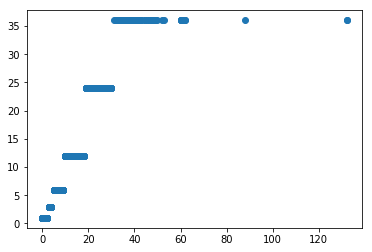

In [119]:
plt.scatter(df_A['months'], df_A['rebill_months'])

## Grouping the dataframe by rebill_months

In [120]:
# drop what we dont need
df_A.drop(columns = ['start_date', 'end_date', 'month_interval', 'months'], axis=1, inplace=True)

In [121]:
df_A.sample(10)

,curr,BU,period,amount,start_date_str,end_date_str,rebill_months
168697,USD,Document Cloud,2017-08,-0.72,20170721,20170801,1.0
206628,USD,Document Cloud,2018-03,-14.56,20180209,20180919,6.0
128937,USD,Document Cloud,2016-11,-43.87,20161012,20170920,12.0
115047,USD,Document Cloud,2016-05,-233.29,20151014,20161013,12.0
6374,AUD,Document Cloud,2016-06,-44.02,20160416,20170415,12.0
245351,USD,Document Cloud,2018-11,-1.03,20181018,20181021,1.0
133912,USD,Document Cloud,2016-12,-466.62,20161031,20171024,12.0
111451,USD,Document Cloud,2015-11,-23.88,20131004,20141003,12.0
250385,USD,Document Cloud,2018-11,-2531.51,20181010,20191009,12.0
71714,GBP,Document Cloud,2017-11,-16.80,20171010,20180922,12.0


In [122]:
df_A['rebill_months'].value_counts()


12.0    107348
6.0      66637
1.0      57684
3.0      23258
24.0       692
36.0       546
Name: rebill_months, dtype: int64

In [123]:
#gb_A = df_A.groupby(['currency', 'BU', 'period'], as_index=False).sum()
# The code above adds the months as well. I do not want this.

In [124]:
#df_A.curr.value_counts()

In [125]:
#medals = df.pivot_table('no of medals', ['Year', 'Country'], 'medal')
temp = df_A.pivot_table('amount', ['curr', 'BU', 'period'], 'rebill_months')

In [126]:
temp.fillna(0)

rebill_months                            1.0           3.0            6.0   \
curr BU                 period                                               
AUD  Creative           2015-06   7410.857222  4.127300e+02       0.000000   
                        2015-08   7284.192982  2.570450e+02       0.000000   
                        2015-09   7122.768056  0.000000e+00       0.000000   
                        2015-10   6726.175517  1.281800e+02       0.000000   
                        2015-11   6896.387241  4.500000e+02       0.000000   
                        2015-12   6904.457222  3.000000e+02       0.000000   
                        2016-01    -11.984000  0.000000e+00       0.000000   
                        2016-02   6664.847500  2.890900e+02     412.730000   
                        2016-03   6219.013333  0.000000e+00       0.000000   
                        2016-05   6710.357931  1.281800e+02       0.000000   
                        2016-06   6174.654531  0.000000e+00     412.730000   
                        2016-07   6045.849310  1.281800e+02       0.000000   
                        2016-08   6202.775862  0.000000e+00       0.000000   
                        2016-09   5923.717778  0.000000e+00       0.000000   
                        2016-10   5948.620000  1.281800e+02       0.000000   
                        2016-11   5906.068276  0.000000e+00       0.000000   
                        2016-12  11460.629459  0.000000e+00     825.460000   
                        2017-02  -5889.663611  0.000000e+00    -412.730000   
                        2017-03   5834.551828  2.140900e+02       0.000000   
                        2017-04   6343.430000  1.281800e+02       0.000000   
                        2017-05   5615.712414  0.000000e+00       0.000000   
                        2017-06   5477.573684  0.000000e+00     412.730000   
                        2017-07    -12.990000  0.000000e+00       0.000000   
                        2017-08   5664.959828  1.281800e+02       0.000000   
                        2017-09   5736.605278  0.000000e+00       0.000000   
                        2017-10   5362.475161  1.281800e+02       0.000000   
                        2017-11   5882.615333  0.000000e+00       0.000000   
                        2017-12   5921.575405  0.000000e+00     412.730000   
                        2018-01   -597.660000  0.000000e+00       0.000000   
                        2018-02    -12.990000  0.000000e+00       0.000000   
...                                       ...           ...            ...   
USD  Print & Publishing 2017-01   1482.777368  0.000000e+00       0.000000   
                        2017-02   7798.284500 -3.683486e+04       0.000000   
                        2017-03  14890.670241  1.947836e+06       0.000000   
                        2017-04  10346.872667  5.770000e+01       0.000000   
                        2017-05   3534.248214  6.486607e+05       0.000000   
                        2017-06  45544.731628  1.137298e+06   33835.615000   
                        2017-07  10565.250357  1.525000e+04       0.000000   
                        2017-08  29010.683333  1.936700e+06       0.000000   
                        2017-09  94512.310000  1.473558e+05  142478.250000   
                        2017-10   2436.216000  1.875000e+04  125376.375000   
                        2017-11   9983.796452  1.480686e+06       0.000000   
                        2017-12  92513.191500  2.195211e+05  129027.113333   
                        2018-01   1321.538462  5.917000e+01       0.000000   
                        2018-02   9568.044848  0.000000e+00       0.000000   
                        2018-03  93621.795000  1.530189e+06   -2700.000000   
                        2018-04   7436.793103  0.000000e+00       0.000000   
                        2018-05  32862.976071  2.119800e+03       0.000000   
                        2018-06  81976.712222  2.158825e+06       0.000000   
                      

In [127]:
temp.rename(columns = {1.0: 'one_month', 3.0:'three_months',
                                 6.0:'six_months', 12.0:'twelve_months',
                                 24.0:'two_years', 36.0:'three_years'}, inplace=True)


In [128]:
temp.columns

Index(['one_month', 'three_months', 'six_months', 'twelve_months', 'two_years',
       'three_years'],
      dtype='object', name='rebill_months')

In [129]:
df.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,4992688.95,0.0,0.0,5828107.10,26443.20
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4115986.40,0.0,0.0,5011194.77,10399.50
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4365814.67,0.0,0.0,3989523.54,2316.62
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5665079.46,0.0,0.0,5841026.18,11534.00
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4646147.74,0.0,0.0,4444738.11,11802.30


In [152]:
temp.head()

rebill_months            one_month  three_months  six_months  twelve_months  \
curr BU       period                                                          
AUD  Creative 2015-06  7410.857222       412.730         NaN    4954.487778   
              2015-08  7284.192982       257.045         NaN    5985.608103   
              2015-09  7122.768056           NaN         NaN    5801.415278   
              2015-10  6726.175517       128.180         NaN    5229.060000   
              2015-11  6896.387241       450.000         NaN    5751.434138   

rebill_months           two_years  three_years  
curr BU       period                            
AUD  Creative 2015-06  608.377500          NaN  
              2015-08  648.305882          NaN  
              2015-09  741.312857          NaN  
              2015-10  597.380000          NaN  
              2015-11  672.630769          NaN

In [131]:
# now I need to combine the new dataframe (df_A) with df
df_merged = pd.merge(df, temp, how='outer', 
                 left_on=['curr', 'BU', 'period'],
                right_on=['curr', 'BU', 'period'])
df_merged = df_merged.fillna(value=0)

In [132]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,one_month,three_months,six_months,twelve_months,two_years,three_years
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,4992688.95,0.0,0.0,5828107.10,26443.20,7410.857222,412.730,0.0,4954.487778,608.377500,0.0
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4115986.40,0.0,0.0,5011194.77,10399.50,0.000000,0.000,0.0,0.000000,0.000000,0.0
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4365814.67,0.0,0.0,3989523.54,2316.62,7284.192982,257.045,0.0,5985.608103,648.305882,0.0
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5665079.46,0.0,0.0,5841026.18,11534.00,7122.768056,0.000,0.0,5801.415278,741.312857,0.0
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4646147.74,0.0,0.0,4444738.11,11802.30,6726.175517,128.180,0.0,5229.060000,597.380000,0.0


In [133]:
#df_merged.curr.value_counts()

In [134]:
df_merged['deferred_1M'] = df_merged['deferred_1M']+df_merged['one_month']
df_merged.drop(labels=['one_month'], axis=1, inplace=True)


In [153]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,412.730,0.0,5.833062e+06,27051.577500
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.0,5.011195e+06,10399.500000
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.0,3.995509e+06,2964.925882
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5.672202e+06,0.000,0.0,5.846828e+06,12275.312857
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4.652874e+06,128.180,0.0,4.449967e+06,12399.680000


In [136]:
df_merged['deferred_3M'] = df_merged['deferred_3M']+df_merged['three_months']
df_merged.drop(labels=['three_months'], axis=1, inplace=True)

df_merged['deferred_6M'] = df_merged['deferred_6M']+df_merged['six_months']
df_merged.drop(labels=['six_months'], axis=1, inplace=True)

df_merged['deferred_1Y'] = df_merged['deferred_1Y']+df_merged['twelve_months']
df_merged.drop(labels=['twelve_months'], axis=1, inplace=True)

df_merged['deferred_2Y'] = df_merged['deferred_2Y']+df_merged['two_years']
df_merged.drop(labels=['two_years'], axis=1, inplace=True)

df_merged['deferred_3Y'] = df_merged['deferred_3Y']+df_merged['three_years']
df_merged.drop(labels=['three_years'], axis=1, inplace=True)


In [137]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,412.730,0.0,5.833062e+06,27051.577500
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.0,5.011195e+06,10399.500000
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.0,3.995509e+06,2964.925882
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5.672202e+06,0.000,0.0,5.846828e+06,12275.312857
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4.652874e+06,128.180,0.0,4.449967e+06,12399.680000


In [138]:
df_merged.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_1M', 'deferred_3M', 'deferred_6M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [139]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,412.730,0.0,5.833062e+06,27051.577500
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.0,5.011195e+06,10399.500000
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.0,3.995509e+06,2964.925882
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5.672202e+06,0.000,0.0,5.846828e+06,12275.312857
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4.652874e+06,128.180,0.0,4.449967e+06,12399.680000


In [154]:
df_merged.tail()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
2810,NOK,Other Solutions,2018-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32891.96,0.0
2811,SEK,Other Solutions,2015-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28800.00,0.0
2812,SEK,Other Solutions,2015-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23580.00,0.0
2813,SEK,Other Solutions,2016-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21600.00,0.0
2814,SEK,Other Solutions,2017-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33934.80,0.0


In [141]:
df_merged['deferred_3M'].describe()

count    2.815000e+03
mean     7.872754e+05
std      3.851819e+06
min     -1.001754e+06
25%      0.000000e+00
50%      0.000000e+00
75%      2.945450e+02
max      4.392479e+07
Name: deferred_3M, dtype: float64

In [142]:
#df_merged.curr.value_counts()

# Loading Currency Data & Period Data

## Currency Map

The currency map is a list of countries (as an index) and the document currency that is the primary billing currency of that country. It is stored as a dataframe with an index ['Country'] and the column ['Currency']

In [143]:
curr_map = pd.read_excel('../data/Data_2019_P06/currency_map.xlsx', 'curr_map')
curr_map['Country'] = curr_map['Country'].map(lambda x: str(x)[:-4])
curr_map.set_index('Country', inplace=True)
curr_map

,Currency
Country,
Aus and New Zealand,AUD
Benelux,EUR
Brazil,USD
Canada,USD
China,USD
Eastern Europe,EUR
France,EUR
Germany,EUR
Hong Kong,USD


## FX Forward Rates
There are three forward rate variables created in this section of code and all are converted from normal currency quotes to indirect quotes such that any conversion back to USD will simply be the exchange rate multiplied by the document currency.

df_FX_rates - is a dataframe. The index to this dataframe is the document currency. The columns are the spot exchange rate and monthly forward exchange rates going out one year. 

FX_rates - is a numpy array containing the same data as the dataframe with the exception of the DC index. 
    rows - number of document currencies
    columns - Spot rate, 1M fwd rate, 2M fwd rate, ., ., ..... 12M fwd rate

list_FX_rates - a list containing the document currency corresponding with the FX_rates array.

In [144]:
def load_forward_rates():
    df_FX_rates = pd.read_excel('../data/Data_2019_P06/FX_data.xlsx', 'to_matlab')
    # converting vols to decimals (bloomberg downloads problem with rates)
    df_FX_rates['VOL_3M'] = df_FX_rates['VOL_3M']/100
    df_FX_rates['VOL_6M'] = df_FX_rates['VOL_6M']/100
    df_FX_rates['VOL_9M'] = df_FX_rates['VOL_9M']/100
    df_FX_rates['VOL_1Y'] = df_FX_rates['VOL_1Y']/100
    
    # invert indirect interest rates so that all currencies are in same format
    to_invert = df_FX_rates['Ticker'].str.slice(0,3).str.contains('USD')
    for index, row in df_FX_rates.iterrows():
         if to_invert.iloc[index] == True:
            df_FX_rates['Spot'].loc[index] = 1/row['Spot']
            df_FX_rates['FWD_3M'].loc[index]  = 1/row['FWD_3M']
            df_FX_rates['FWD_6M'].loc[index]  = 1/row['FWD_6M']
            df_FX_rates['FWD_9M'].loc[index]  = 1/row['FWD_9M']
            df_FX_rates['FWD_1Y'].loc[index]  = 1/row['FWD_1Y']
            
    # Interpolating the forward rates
    df_FX_rates['FWD_1M'] = df_FX_rates['Spot']* (2/3) + df_FX_rates['FWD_3M']*(1/3)
    df_FX_rates['FWD_2M'] = df_FX_rates['Spot']* (1/3) + df_FX_rates['FWD_3M']*(2/3)

    df_FX_rates['FWD_4M'] = df_FX_rates['FWD_3M']* (2/3) + df_FX_rates['FWD_6M']*(1/3)
    df_FX_rates['FWD_5M'] = df_FX_rates['FWD_3M']* (1/3) + df_FX_rates['FWD_6M']*(2/3)

    df_FX_rates['FWD_7M'] = df_FX_rates['FWD_6M']* (2/3) + df_FX_rates['FWD_9M']*(1/3)
    df_FX_rates['FWD_8M'] = df_FX_rates['FWD_6M']* (1/3) + df_FX_rates['FWD_9M']*(2/3)

    df_FX_rates['FWD_10M'] = df_FX_rates['FWD_9M']* (2/3) + df_FX_rates['FWD_1Y']*(1/3)
    df_FX_rates['FWD_11M'] = df_FX_rates['FWD_9M']* (1/3) + df_FX_rates['FWD_1Y']*(2/3)

    
    df_FX_rates.drop(['Ticker', 'VOL_3M', 'VOL_6M', 'VOL_9M', 'VOL_1Y'], axis=1, inplace=True)
    df_FX_rates.set_index('DC', inplace=True)
    
    sorted_columns = ['Spot', 'FWD_1M', 'FWD_2M','FWD_3M',
           'FWD_4M','FWD_5M','FWD_6M',
           'FWD_7M','FWD_8M','FWD_9M',
           'FWD_10M','FWD_11M','FWD_1Y']
    df_FX_rates = df_FX_rates[sorted_columns]
    
    list_FX_rates = df_FX_rates.index.to_list()
    FX_rates = df_FX_rates.to_numpy()
    
    return df_FX_rates, FX_rates, list_FX_rates

In [145]:
df_FX_rates, FX_rates, list_FX_rates = load_forward_rates()

C:\Users\davsmith\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## FX Plan Rates 

This section pulls in plan forward rates in order to back into the document currency billings. (FP&A provides net new billings forecasts in terms of USD by country. The currency map is used to determine the primary currency of these billings and the forward rates are used to back these USD billings into document currency.)

book_FX_rates is a dataframe with an index['Currency'] and one column ['forward']. 

NOTE: The forward rates are all in terms direct.

In [146]:
book_FX_rates = pd.read_excel('../data/Data_2019_P06/FX_forward_rates.xlsx', sheet_name='forward_data', 
                        header=1,   index_col=1)

# dropping columns that are completely blank
book_FX_rates.dropna(how='all', axis='columns', inplace=True)

# first rename one of the unnamed columns that you intend to keep
# then delete the other unnamed columns
book_FX_rates.rename( columns={'Unnamed: 2': 'Currency', 'FWD REF':'forward'}, inplace=True)
                               
book_FX_rates.drop(['Pricing Date', 91, 'PX ASK', '% Change', 'SPOT', 'FWD'], axis=1, inplace=True)
book_FX_rates.set_index('Currency', inplace=True)
book_FX_rates

,forward
Currency,
AED,3.673964
AUD,1.439320
BBD,2.013300
BMD,1.000000
BRL,3.954754
CAD,1.349750
CHF,0.993608
CLP,711.160000
COP,3399.421300


## Period Weeks
This section loads an excel file that contains the number of weeks in a period. 

Note: In the future this should be changed to be pulled directly from the ADOBE_FINANCIAL_CALENDAR datbase.

In [147]:
df_period_weeks = pd.read_excel('../data/Data_2019_P06/Period_weeks.xlsx', sheet_name='period_weeks')
df_period_weeks.set_index('Period', inplace=True)
df_period_weeks.sample(10)

,Weeks
Period,
2020-03,5
2018-07,4
2017-10,4
2022-09,5
2019-08,4
2023-02,4
2021-12,5
2018-01,4
2016-01,5


In [148]:
whos

Variable               Type         Data/Info
---------------------------------------------
FX_rates               ndarray      21x13: 273 elems, type `float64`, 2184 bytes
LinearRegression       ABCMeta      <class 'sklearn.linear_mo<...>l.base.LinearRegression'>
ZCC_curr               ndarray      11: 11 elems, type `object`, 88 bytes
ZCC_isna               Series       0        True\n1       Fa<...>Length: 5165, dtype: bool
a                      Index        Index(['USD', 'EUR', 'GBP<...>],\n      dtype='object')
add_ZCC_periods        function     <function add_ZCC_periods at 0x00000184ED55E9D8>
book_FX_rates          DataFrame                   forward\nC<...>7\nTHB          31.510250
clean_df_columns       function     <function clean_df_columns at 0x00000184ED277400>
config_list            list         n=4
curr_map               DataFrame                          Cur<...>d States              USD
df                     DataFrame         curr                <...>n[2778 rows x 12

In [149]:
df_merged.head(20)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,412.730,0.00,5.833062e+06,27051.577500
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.00,5.011195e+06,10399.500000
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.00,3.995509e+06,2964.925882
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5.672202e+06,0.000,0.00,5.846828e+06,12275.312857
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4.652874e+06,128.180,0.00,4.449967e+06,12399.680000
5,AUD,Creative,2015-11,361723.22,0.0,0.0,0.0,5.084470e+06,450.000,0.00,3.487610e+06,33072.130769
6,AUD,Creative,2015-12,276178.28,0.0,0.0,0.0,6.508168e+06,300.000,0.00,1.169531e+07,21287.755625
7,AUD,Creative,2016-01,270306.21,0.0,0.0,0.0,6.703052e+06,0.000,0.00,3.722175e+06,37020.000000
8,AUD,Creative,2016-02,116996.45,0.0,0.0,0.0,5.470467e+06,289.090,412.73,4.163052e+06,7607.473684
9,AUD,Creative,2016-03,235382.84,0.0,0.0,0.0,7.497134e+06,0.000,0.00,5.749068e+06,37216.813636


# Messing with the forecast file

In [155]:
df_fcst = pd.DataFrame(columns=['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
                                'deferred_1M','deferred_3M','deferred_6M','deferred_1Y',
                                'deferred_2Y','deferred_3Y'])

In [156]:
df_fcst

,curr,BU,period,recognized,service,deferred_B,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,deferred_3Y


In [157]:
df_merged.tail()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
2810,NOK,Other Solutions,2018-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32891.96,0.0
2811,SEK,Other Solutions,2015-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28800.00,0.0
2812,SEK,Other Solutions,2015-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23580.00,0.0
2813,SEK,Other Solutions,2016-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21600.00,0.0
2814,SEK,Other Solutions,2017-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33934.80,0.0


First attempt
create unique list of BUs and Currencies
loop through these and then copy over recognized and service billings and move through the columns indexing the others

##  Create period list

In [187]:
per = df_merged['period'].unique()
per.sort()
last_period = per[-1]
last_period

'2019-06'

In [159]:
def build_fcst_periods(last_period, numb_periods):
    this_year = last_period[0:4]
    int_year = int(this_year)
    
    this_month = last_period[-2:]
    int_month = int(this_month)
    list_periods =[]
    
    for per in range(num_periods):
        int_month = int_month + 1
        if int_month > 12:
            int_month = 1
            int_year += 1
        
        if int_month < 10:
            temp_month_str = '0'+str(int_month)
        else:
            temp_month_str = str(int_month)
            
        list_periods.append(str(int_year)+'-'+temp_month_str)
    return list_periods
    

In [188]:
num_periods = 12
list_periods= build_fcst_periods(last_period, num_periods)
list_periods

['2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-01',
 '2020-02',
 '2020-03',
 '2020-04',
 '2020-05',
 '2020-06']

## Create list of unique currencies and BUs

In [189]:
# creating unique lists of currency and BU
list_curr = df_merged['curr'].unique()
print('list_curr: ', list_curr)

list_BU = df_merged['BU'].unique()
print('list_BU: ', list_BU)


list_curr:  ['AUD' 'BRL' 'CAD' 'CHF' 'DKK' 'EUR' 'GBP' 'HKD' 'JPY' 'KRW' 'NOK' 'NZD'
 'RUB' 'SEK' 'SGD' 'USD' 'ARS' 'CLP' 'COP' 'PEN' 'MXP']
list_BU:  ['Creative' 'Document Cloud' 'Experience Cloud' 'LiveCycle'
 'Other Solutions' 'Print & Publishing']


0

In [201]:
def forecast_1M_billings(this_df, df_period_weeks):
    def_1M = this_df['deferred_1M'].to_numpy()
    def_1M = def_1M.reshape(-1,1)

    #adjust for period weeks
    x = np.arange(len(def_1M))
    x = x.reshape(-1,1)

    all_weeks = df_period_weeks['Weeks'].to_numpy()
    all_weeks = all_weeks.reshape(-1,1)
    weeks = all_weeks[0:len(x)]
    weeks = weeks.reshape(-1,1)
    fcst_weeks = all_weeks[len(x):len(x)+12]
    fcst_weeks = fcst_weeks.reshape(-1,1)

    # divide the billings by the number of weeks in the period
    def_1M_wkly= np.true_divide(def_1M, weeks)

    x_fcst = np.arange(len(def_1M_wkly), len(def_1M)+12)
    x_fcst = x_fcst.reshape(-1,1)

    #fitting a linear regression
    model = LinearRegression()
    model.fit(x, def_1M_wkly)

    #predicting the 1M billings based on linear model
    def_1M_fcst_wkly = model.predict(x_fcst)

    #adjust for the period weeks
    def_1M_fcst = def_1M_fcst_wkly * fcst_weeks
    
    return def_1M_fcst

In [284]:
# creating some sort of massive loop to start
def create_forecast_dataframe(df_merged, df_period_weeks):
    '''
    This function takes the billings history and creates a forecast of future billings
    One Month deferred billings are a linear trend forecast, while all other deferred billings are based on their history repeating
    Service, Deferred type B and Recognized Billings recurr at their 12 month average

    INPUTS: df_merged - the billings forecast
            df_period_weeks - historical weeks in each billing quarter
    '''
    #creating a blank df_fcst dataframe
    df_fcst = pd.DataFrame(columns=['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
                                'deferred_1M','deferred_3M','deferred_6M','deferred_1Y',
                                'deferred_2Y','deferred_3Y'])    

    #looping through every currency
    for this_curr in list_curr:

        v_this_curr = np.empty((12,1)).astype(str)
        v_this_curr[:]=this_curr

        #looping through every BU
        for this_BU in list_BU:
            print(this_curr, ' : ', this_BU)
            v_this_BU = np.empty((12,1)).astype(str)
            v_this_BU[:]=this_BU

            # pulling historical billings for this currency and BU pair
            this_df = df_merged[(df_merged['curr']==this_curr) & (df_merged['BU']==this_BU)]
            print('Lenght of this dataframe: ', len(this_df))
            
            # for the cases where this particular BU does not have a complete history, we need to 
            # add every period to the dataframe with zeros for the billings
            this_df = add_all_periods(this_df, df_merged, this_curr, this_BU)
            
            # pulling historical billings information as the forecast
            # recognized - use average of last 12 months
            v_recognized = this_df['recognized'].iloc[-12:].to_numpy()
            avg_recognized = np.mean(v_recognized)
            recognized = np.ones(12)*avg_recognized

            # service - use average of last 12 months
            v_svc = this_df['service'].iloc[-12:].to_numpy()
            avg_svc = np.mean(v_svc)
            service = np.ones(12)*avg_svc

            # deferred B
            v_def_B = this_df['deferred_B'].iloc[-12:].to_numpy()
            avg_def_B = np.mean(v_def_B)
            deferred_B = np.ones(12)*avg_def_B

            # pulling historical billings information as the forecast
            deferred_3Y = this_df['deferred_3Y'].iloc[-36:-24].to_numpy()
            deferred_2Y = this_df['deferred_2Y'].iloc[-24:-12].to_numpy()
            deferred_1Y = this_df['deferred_1Y'].iloc[-12:].to_numpy()

            deferred_6M_p1 = this_df['deferred_6M'].iloc[-6:].to_numpy()           
            deferred_6M = np.concatenate((deferred_6M_p1, deferred_6M_p1),axis=0)

            deferred_3M_p1 = this_df['deferred_3M'].iloc[-3:].to_numpy()
            deferred_3M_half = np.concatenate((deferred_3M_p1,deferred_3M_p1), axis=0)
            deferred_3M = np.concatenate((deferred_3M_half,deferred_3M_half), axis=0)

            # deferred 1 Month
            def_1M_fcst = forecast_1M_billings(this_df, df_period_weeks)

            # put fields together into a dataframe
            temp_dict = ({'curr':v_this_curr.flatten(), 
              'BU': v_this_BU.flatten(), 
              'period':v_periods.flatten(),
              'recognized': recognized.flatten(),
              'service': service.flatten(),
              'deferred_B': deferred_B.flatten(),
              'deferred_1M':def_1M_fcst.flatten(),
              'deferred_3M': deferred_3M.flatten(),
              'deferred_6M': deferred_6M.flatten(), 
              'deferred_1Y': deferred_1Y.flatten(),
              'deferred_2Y': deferred_2Y.flatten(),
              'deferred_3Y': deferred_3Y.flatten()})
            temp_df = pd.DataFrame(temp_dict)

            print('length of temp_df: ', len(temp_df))
            #need to merge temp_df with the other dataframe df_fcst
            #frames = [df_fcst, temp_df]
            #df_fcast = pd.concat(frames)
            df_fcst = pd.concat([df_fcst, temp_df], ignore_index=True)

    return df_fcast

In [288]:
#df_test1 = create_forecast_dataframe(df_merged, df_period_weeks)

In [310]:
a = pd.DataFrame(columns=['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
                                'deferred_1M','deferred_3M','deferred_6M','deferred_1Y',
                                'deferred_2Y','deferred_3Y'])    
b = pd.concat([a, df_fcst], ignore_index=True)
b

,curr,BU,period,recognized,service,deferred_B,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,deferred_3Y


In [309]:
#a = a.append(df_fcst)
a = a.append(df_fcst, ignore_index=True)
a

,curr,BU,period,recognized,service,deferred_B,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,deferred_3Y


In [306]:
df_fcast

,curr,BU,period,recognized,service,deferred_B,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,deferred_3Y
0,MXP,Print & Publishing,2019-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MXP,Print & Publishing,2019-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MXP,Print & Publishing,2019-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MXP,Print & Publishing,2019-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MXP,Print & Publishing,2019-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,MXP,Print & Publishing,2019-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,MXP,Print & Publishing,2020-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,MXP,Print & Publishing,2020-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,MXP,Print & Publishing,2020-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,MXP,Print & Publishing,2020-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [275]:
this_df = df_merged[(df_merged['curr']=='AUD') & (df_merged['BU']=='Other Solutions')]
this_df = this_df.sort_values(by=['period'])
#this_df

In [225]:
# need to create a function that adds in every period to this dataframe
all_periods = df_merged['period'].unique()
all_periods.sort()
all_periods

array(['2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09',
       '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
       '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09',
       '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03',
       '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09',
       '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
       '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09',
       '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
       '2019-04', '2019-05', '2019-06'], dtype=object)

In [270]:
def add_all_periods(this_df, df_merged, this_curr, this_BU):
    
    all_periods=df_merged['period'].unique()
    all_periods = np.sort(all_periods)
    
    temp_periods = this_df['period']
    
    set_all_periods = set(all_periods)
    set_temp_periods = set(temp_periods)
    add_these_periods = set_all_periods - set_temp_periods
    
    for item in add_these_periods:
        this_df = this_df.append({'curr': this_curr, 'BU': this_BU, 'period':item}, ignore_index=True)
    
    this_df = this_df.fillna(0)
    this_df = this_df.sort_values(by=['period'])
    
    return this_df
    

In [269]:
all_periods = df_merged['period'].unique()
all_periods = np.sort(all_periods)
all_periods

array(['2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09',
       '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
       '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09',
       '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03',
       '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09',
       '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
       '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09',
       '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
       '2019-04', '2019-05', '2019-06'], dtype=object)

In [254]:
for item in add_these_periods:
    this_df = this_df.append({'curr': this_curr, 'BU': this_BU, 'period':item}, ignore_index=True)

this_df = this_df.sort_values(by='period')
#this_df

23

In [196]:

x = np.arange(len(def_1M))
x = x.reshape(-1,1)

all_weeks = df_period_weeks['Weeks'].to_numpy()
all_weeks = all_weeks.reshape(-1,1)
weeks = all_weeks[0:len(x)]
weeks = weeks.reshape(-1,1)
fcst_weeks = all_weeks[len(x):len(x)+12]
fcst_weeks = fcst_weeks.reshape(-1,1)

def_1M_wkly= np.true_divide(def_1M, weeks)

x_fcst = np.arange(len(def_1M_wkly), len(def_1M)+12)
x_fcst = x_fcst.reshape(-1,1)
model = LinearRegression()
model.fit(x, def_1M_wkly)
def_1M_fcst_wkly = model.predict(x_fcst)

def_1M_fcst = def_1M_fcst_wkly * fcst_weeks
#adjust for the period weeks


In [206]:
testX = np.concatenate((x, x_fcst), axis=0)
testY = np.concatenate((def_1M_wkly, def_1M_fcst_wkly), axis=0)


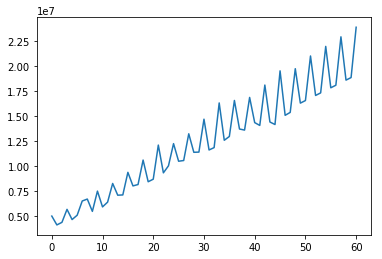

In [198]:
tempX = np.concatenate((x, x_fcst), axis=0)
tempY = np.concatenate((def_1M, def_1M_fcst), axis=0)
plt.plot(tempX, tempY)

In [175]:
# assigning these to a dataframe
t_index = np.arange(12)
t_index.reshape(-1,1)
v_periods = np.asarray(list_periods)
temp_dict = ({'curr':v_this_curr, 'BU': v_this_BU, 'period':v_periods.reshape(-1,1),
              'recognized': recognized.reshape(-1,1),
              'service': service.reshape(-1,1),
              'deferred_B': deferred_B.reshape(-1,1),
              'deferred_1M':def_1M_fcst.reshape(-1,1),
              'deferred_3M': deferred_3M.reshape(-1,1),
              'deferred_6M': deferred_6M.reshape(-1,1), 
              'deferred_1Y': deferred_1Y.reshape(-1,1),
              'deferred_2Y': deferred_2Y.reshape(-1,1),
              'deferred_3Y': deferred_3Y.reshape(-1,1)})

In [199]:
temp_dict = ({'curr':v_this_curr.flatten(), 
              'BU': v_this_BU.flatten(), 
              'period':v_periods.flatten(),
              'recognized': recognized.flatten(),
              'service': service.flatten(),
              'deferred_B': deferred_B.flatten(),
              'deferred_1M':def_1M_fcst.flatten(),
              'deferred_3M': deferred_3M.flatten(),
              'deferred_6M': deferred_6M.flatten(), 
              'deferred_1Y': deferred_1Y.flatten(),
              'deferred_2Y': deferred_2Y.flatten(),
              'deferred_3Y': deferred_3Y.flatten()})
temp_df = pd.DataFrame(temp_dict)


In [200]:
temp_df

,curr,BU,period,recognized,service,deferred_B,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,deferred_3Y
0,AUD,Creative,2019-07,169056.084167,0.0,0.0,1.630115e+07,0.0,0.0,1.046606e+07,3072.000,0.0
1,AUD,Creative,2019-08,169056.084167,0.0,0.0,1.655672e+07,0.0,0.0,8.389952e+06,12100.000,0.0
2,AUD,Creative,2019-09,169056.084167,0.0,0.0,2.101537e+07,0.0,0.0,1.315832e+07,1561.000,0.0
3,AUD,Creative,2019-10,169056.084167,0.0,0.0,1.706787e+07,0.0,0.0,7.880099e+06,4938.690,0.0
4,AUD,Creative,2019-11,169056.084167,0.0,0.0,1.732344e+07,0.0,0.0,6.713268e+06,24915.035,0.0
5,AUD,Creative,2019-12,169056.084167,0.0,0.0,2.197377e+07,0.0,0.0,2.223955e+07,14471.490,0.0
6,AUD,Creative,2020-01,169056.084167,0.0,0.0,1.783459e+07,0.0,0.0,8.864629e+06,272.700,0.0
7,AUD,Creative,2020-02,169056.084167,0.0,0.0,1.809017e+07,0.0,0.0,7.382928e+06,64.000,0.0
8,AUD,Creative,2020-03,169056.084167,0.0,0.0,2.293218e+07,0.0,0.0,1.307520e+07,12363.320,0.0
9,AUD,Creative,2020-04,169056.084167,0.0,0.0,1.860132e+07,0.0,0.0,8.961752e+06,9129.730,0.0


In [ ]:
# now work on the merging of the temp_df with the fcst_df

In [209]:
frames = [df_fcst, temp_df]
df_fcast = pd.concat(frames)

In [273]:
df_fcast

,curr,BU,period,recognized,service,deferred_B,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,deferred_3Y
0,MXP,Print & Publishing,2019-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MXP,Print & Publishing,2019-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MXP,Print & Publishing,2019-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MXP,Print & Publishing,2019-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MXP,Print & Publishing,2019-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,MXP,Print & Publishing,2019-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,MXP,Print & Publishing,2020-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,MXP,Print & Publishing,2020-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,MXP,Print & Publishing,2020-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,MXP,Print & Publishing,2020-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
